<a href="https://colab.research.google.com/github/KoNozaki/quantmacro-hw/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 経済成長

労働生産性の成長率を、技術進歩(TFP)と資本深化(capital deepening)に分解する成長会計を実行するプログラムを書いて提出してください(ipynbでPythonを推奨)。

対象国は”France”, ”Germany”, ”Canada”, ”Italy”, ”Japan”, ”United Kingdom”, ”United States”。 

サンプル期間は1995年から2019年。

プログラムが最後まで走るかどうか、技術進歩(TFP)と資本深化(capital deepening)それぞれのレベルおよび寄与度について、Project2(growth accounting)にあるTable5.1のように結果を示しているかチェックします。

# 20

19を編集

計算式を変更


In [31]:
import pandas as pd

# 対象国とサンプル期間を設定
countries = ["France", "Germany", "Canada", "Italy", "Japan", "United Kingdom", "United States"]
start_year = 1995
end_year = 2019

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# 対象国のデータを抽出し、必要な列を選択します。
data = pwt90.loc[pwt90['country'].isin(countries)][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]
# フィルタ条件として、指定されたサンプル期間のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= start_year) & (data['year'] <= end_year)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])


# 対象国ごとの成長率データを表示
averages = pd.DataFrame(columns=['Country', 'Average Growth Rate', 'Average TFP Growth', 'Average Capital Deepening', 'Average TFP Share', 'Average Capital Share'])

for country, group in grouped_data:
    average_growth_rate = group['g'].mean()
    average_tfp_growth = group['tfp_g'].mean()
    average_capital_deepening = group['capital_deepening'].mean()
    average_tfp_share =    group['tfp_share'].mean()
    average_capital_share = group['capital_share'].mean()

    averages = averages.append({
        'Country': country,
        'Average Growth Rate': average_growth_rate,
        'Average TFP Growth': average_tfp_growth,
        'Average Capital Deepening': average_capital_deepening,
        'Average TFP Share': average_tfp_share,
        'Average Capital Share': average_capital_share
    }, ignore_index=True)

# 平均成長率の表を表示
print(averages)



  Country  Average Growth Rate  Average TFP Growth  Average Capital Deepening  \
0     CAN            79.997047           16.559118                  69.537231   
1     DEU            73.696938           80.495018                 105.138390   
2     FRA            88.586945           42.637959                  15.293203   
3     GBR           122.854301          109.131462                 -59.570061   
4     ITA             4.365740         -126.446777                 121.346283   
5     JPN            99.276138            6.295416                 235.091766   
6     USA           185.522858          174.879959                  14.410724   

   Average TFP Share  Average Capital Share  
0           0.494332               0.505668  
1           0.483984               0.516016  
2           0.519665               0.480335  
3           0.567660               0.432340  
4           0.442444               0.557556  
5           0.435932               0.564067  
6           0.549406         

<ipython-input-31-5732d013edf8>:23: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
<ipython-input-31-5732d013edf8>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-31-5732d013edf8>:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-31-5732d013edf8>:59: FutureWarning: The frame.append method is depreca

# 19

18を編集

平均でグルーピング

サイズ感は似てるけどコードが怪しい

In [23]:
import pandas as pd

# 対象国とサンプル期間を設定
countries = ["France", "Germany", "Canada", "Italy", "Japan", "United Kingdom", "United States"]
start_year = 1995
end_year = 2019

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# 対象国のデータを抽出し、必要な列を選択します。
data = pwt90.loc[pwt90['country'].isin(countries)][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]
# フィルタ条件として、指定されたサンプル期間のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= start_year) & (data['year'] <= end_year)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))

# データの整形
data = data.sort_values(['countrycode', 'year'])
grouped_data = data.groupby('countrycode')

# 対象国ごとに成長率データを計算
data['g'] = grouped_data['y_n'].pct_change() * 100  # Growth Rate
data['tfp_g'] = grouped_data['tfp_term'].pct_change() * 100  # TFP Growth
data['capital_deepening'] = grouped_data['cap_term'].pct_change() * 100  # Capital Deepening
data['tfp_share'] = data['tfp_term'] / (data['tfp_term'] + data['cap_term'])  # TFP Share
data['capital_share'] = data['cap_term'] / (data['tfp_term'] + data['cap_term'])  # Capital Share

# 対象国ごとの成長率データを表示
averages = pd.DataFrame(columns=['Country', 'Average Growth Rate', 'Average TFP Growth', 'Average Capital Deepening', 'Average TFP Share', 'Average Capital Share'])

for country, group in grouped_data:
    average_growth_rate = group['g'].mean()
    average_tfp_growth = group['tfp_g'].mean()
    average_capital_deepening = group['capital_deepening'].mean()
    average_tfp_share =    group['tfp_share'].mean()
    average_capital_share = group['capital_share'].mean()

    averages = averages.append({
        'Country': country,
        'Average Growth Rate': average_growth_rate,
        'Average TFP Growth': average_tfp_growth,
        'Average Capital Deepening': average_capital_deepening,
        'Average TFP Share': average_tfp_share,
        'Average Capital Share': average_capital_share
    }, ignore_index=True)

# 平均成長率の表を表示
print(averages)



  Country  Average Growth Rate  Average TFP Growth  Average Capital Deepening  \
0     CAN             0.754012            0.177662                   0.707206   
1     DEU             0.710376            0.777262                   1.007133   
2     FRA             0.826450            0.429084                   0.162240   
3     GBR             1.118919            1.019163                  -0.563073   
4     ITA             0.054003           -1.404294                   1.176354   
5     JPN             0.929897            0.087969                   1.999261   
6     USA             1.606287            1.529652                   0.172438   

   Average TFP Share  Average Capital Share  
0           0.318552               0.681448  
1           0.298309               0.701691  
2           0.286379               0.713621  
3           0.279532               0.720468  
4           0.208875               0.791125  
5           0.315470               0.684530  
6           0.314112         

<ipython-input-23-f0ccf7844e34>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-23-f0ccf7844e34>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-23-f0ccf7844e34>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-23-f0ccf7844e34>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({
<ipython-input-23-f0ccf7844e34>:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  averages = averages.append({


# 18

3を編集
良さげ

In [21]:
import pandas as pd

# 対象国とサンプル期間を設定
countries = ["France", "Germany", "Canada", "Italy", "Japan", "United Kingdom", "United States"]
start_year = 1995
end_year = 2019

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# 対象国のデータを抽出し、必要な列を選択します。
data = pwt90.loc[pwt90['country'].isin(countries)][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]
# フィルタ条件として、指定されたサンプル期間のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= start_year) & (data['year'] <= end_year)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))

# データの整形
data = data.sort_values(['countrycode', 'year'])
grouped_data = data.groupby('countrycode')

# 対象国ごとに成長率データを計算
data['g'] = grouped_data['y_n'].pct_change() * 100  # Growth Rate
data['tfp_g'] = grouped_data['tfp_term'].pct_change() * 100  # TFP Growth
data['capital_deepening'] = grouped_data['cap_term'].pct_change() * 100  # Capital Deepening
data['tfp_share'] = data['tfp_term'] / (data['tfp_term'] + data['cap_term'])  # TFP Share
data['capital_share'] = data['cap_term'] / (data['tfp_term'] + data['cap_term'])  # Capital Share

# 対象国ごとの成長率データを表示
for country, group in grouped_data:
    print(f"Country: {country}")
    print(group[['year', 'g', 'tfp_g', 'capital_deepening', 'tfp_share', 'capital_share']])
    print("\n")

Country: CAN
      year         g     tfp_g  capital_deepening  tfp_share  capital_share
1995  1995       NaN       NaN                NaN   0.323355       0.676645
1996  1996  0.822711 -1.234663           2.641332   0.314991       0.685009
1997  1997  2.092946  2.467775          -0.506842   0.321381       0.678619
1998  1998  1.719773  1.906538          -3.404343   0.333164       0.666836
1999  1999  2.340758  2.733648           3.111315   0.332349       0.667651
2000  2000  2.788281  3.522515           2.133942   0.335353       0.664647
2001  2001  0.422561 -0.347930          -0.440907   0.335561       0.664439
2002  2002  0.185740  0.653386          -0.896060   0.339028       0.660972
2003  2003 -0.616580 -0.724673           3.345168   0.330084       0.669916
2004  2004  1.147628 -0.540805           2.143741   0.324222       0.675778
2005  2005  1.415431  1.306164           3.094721   0.320399       0.679601
2006  2006  0.484812 -0.496900          -1.422638   0.322438       0.677562

# 17

お手本？

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load data
pwt10 = pd.read_stata('https://dataverse.nl/api/access/datafile/354098')
# Filter and select relevant columns
data = pwt10.loc[pwt10['country'].isin(["France","Germany","Canada","Italy","Japan","United Kingdom","United States"])][['year', 'countrycode', 'rgdpna', 'rkna', 'emp', 'labsh']]
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()
# Calculate additional columns
data['a'] = 1 - data['labsh']  # 資本の所得割合（Capital's Share of Income）
data['KL'] = (data['rkna']**data['a']) * (data['emp']**(1 - data['a']))
data['A'] = data['rgdpna'] / ((data['rkna']**data['a']) * (data['emp']**(1 - data['a'])))  # 総要素生産性（Total Factor Productivity, TFP）
data['Y'] = data['rgdpna']  # 国内総生産（Gross Domestic Product, GDP）

data['logy'] = np.log(data['rgdpna'] / data['emp'])  # Log GDP per worker
data['logk'] = np.log(data['KL'] / data['emp'])  # Log Capital per worker
data['logA'] = np.log(data['A'])




# Calculate time differences
data['dt'] = data['year'].diff()  # Time difference


# Calculate differentials
data['dlogy_dt'] = data['logy'].diff() / data['dt']
data['dlogk_dt'] = data['logk'].diff() / data['dt']
data['dlogA_dt'] = data['logA'].diff() / data['dt']


# 年度でソート
data = data.sort_values('year')

# ISOコードでグループ化
grouped_data = data.groupby('countrycode')


# TFP成長率と資本深化率を計算
data['TFP_growth'] = data['dlogA_dt'] * 100  # TFP成長率
data['capital_deepening'] = data['dlogk_dt'] * 100  # 資本深化率
data['GDP_growth'] = data['dlogy_dt'] * 100  # 経済成長率（GDP成長率）


# 欠損値を削除
data = data.dropna()


# サマリー統計量を計算
summary = data.groupby('countrycode').agg({'GDP_growth': 'mean',
                                           'capital_deepening': 'mean',
                                           'TFP_growth': 'mean'})


# TFP寄与率と資本深化寄与率を計算
summary['TFP寄与率'] = summary['TFP_growth'] / summary['GDP_growth'] * 100
summary['資本深化寄与率'] = summary['capital_deepening'] / summary['GDP_growth'] * 100

# 結果を表示
print(summary)

             GDP_growth  capital_deepening  TFP_growth       TFP寄与率  \
countrycode                                                           
CAN            0.887700           0.239437    0.648264    73.027397   
DEU            0.662448           0.161122    0.501324    75.677399   
FRA            0.816542           0.603822    0.212720    26.051325   
GBR            1.036837           1.311810   -0.274969   -26.520018   
ITA           -0.045964           0.503274   -0.549236  1194.914917   
JPN            0.757615           0.036508    0.721106    95.181152   
USA            1.440635           0.605465    0.835166    57.972073   

                 資本深化寄与率  
countrycode               
CAN            26.972775  
DEU            24.322161  
FRA            73.948730  
GBR           126.520309  
ITA         -1094.921265  
JPN             4.818804  
USA            42.027660  


# 16

授業コード無視してGPT

In [2]:
import pandas as pd

# データの読み込み
url = 'https://www.rug.nl/ggdc/docs/pwt90.dta'
pwt90 = pd.read_stata(url)

# 対象国のリスト
countries = ['FRA', 'DEU', 'CAN', 'ITA', 'JPN', 'GBR', 'USA']

# サンプル期間の範囲
start_year = 1995
end_year = 2019

# 必要な列を選択
pwt90_selected = pwt90[(pwt90['countrycode'].isin(countries)) & (pwt90['year'].between(start_year, end_year))]
pwt90_selected = pwt90_selected[['countrycode', 'year', 'rgdpe', 'rgdpna', 'rkna', 'labsh', 'emp', 'avh', 'hc']]
_
# GDPの計算
pwt90_selected['gdp'] = pwt90_selected['rgdpe'] / pwt90_selected['rgdpna']

# 労働生産性の計算
pwt90_selected['labor_productivity'] = pwt90_selected['gdp'] / (pwt90_selected['emp'] * pwt90_selected['avh'])

# 技術進歩 (TFP) の計算
pwt90_selected['tfp'] = pwt90_selected['labor_productivity'] / (pwt90_selected['hc'] ** 0.3)

# 資本深化の計算
pwt90_selected['capital_deepening'] = pwt90_selected['labor_productivity'] - pwt90_selected['tfp']

# グループごとに成長率を計算
pwt90_selected['gdp_growth'] = pwt90_selected.groupby('countrycode')['gdp'].pct_change() * 100
pwt90_selected['tfp_growth'] = pwt90_selected.groupby('countrycode')['tfp'].pct_change() * 100
pwt90_selected['capital_deepening_growth'] = pwt90_selected.groupby('countrycode')['capital_deepening'].pct_change() * 100

# TFP割合と資本割合の計算
pwt90_selected['tfp_share'] = (pwt90_selected['tfp'] / pwt90_selected['labor_productivity']) * 100
pwt90_selected['capital_share'] = (pwt90_selected['capital_deepening'] / pwt90_selected['labor_productivity']) * 100

# 出力
output_columns = ['countrycode', 'gdp_growth', 'tfp_growth', 'capital_deepening_growth', 'tfp_share', 'capital_share']
output = pwt90_selected.groupby('countrycode')[output_columns].mean().reset_index()
print(output)

  countrycode  gdp_growth  tfp_growth  capital_deepening_growth  tfp_share  \
0         CAN   -0.066903   -1.691234                 -1.289099  68.314653   
1         DEU    0.918844    0.829105                  1.060994  68.105578   
2         FRA    1.089861    0.658244                  1.204607  72.136279   
3         GBR    0.491536   -0.512550                  0.032622  68.217731   
4         ITA    0.995628    0.742247                  1.581398  72.911659   
5         JPN   -0.277800    0.201417                  0.625776  69.218600   
6         USA    0.049630   -0.630543                 -0.357945  67.939994   

   capital_share  
0      31.685347  
1      31.894422  
2      27.863721  
3      31.782269  
4      27.088341  
5      30.781400  
6      32.060006  


<ipython-input-2-e551b079db74>:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  output = pwt90_selected.groupby('countrycode')[output_columns].mean().reset_index()


# 15

12の無駄をなくしたい

In [3]:
import pandas as pd

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = np.log(data['rgdpna'] / data['emp'] ).diff()/data["year"].diff()
data['tfp_term'] = np.log(data['rtfpna'] ** (1 / (1 - data['alpha']))).diff()/data["year"].diff()
data['cap_term'] = np.log((data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))).diff()/data["year"].diff()

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 欠損値削除
data = data.dropna()

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate   TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                           
DEU          -124.253395  -563.566772        -624.704590   6.621400   
FRA          -625.397827 -2040.142090       -1584.057617   1.039710   
GBR          -358.469513    49.513763         262.784424   0.653625   
ITA          -296.658661   162.585861        -157.580597  -1.131165   
JPN          -720.236511  1548.815552        -451.016083   3.038786   
USA         -1108.767456   -76.237793       -1662.312134   0.279564   

             Capital Share  
countrycode                 
DEU              -5.621400  
FRA              -0.039710  
GBR               0.346375  
ITA               2.131165  
JPN              -2.038787  
USA               0.720436  

Average:
Growth Rate         -538.963867
TFP Growth          -153.171936
Capital Deepening   -702.814453
TFP Share              1.750320
Capital Share         -0.750320
dtype: float32


<ipython-input-3-290edf4e01d5>:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 14作目

12作目の修正

平均取れてない？のを治したい←わからん

In [4]:
import pandas as pd

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp'] 
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
#grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 欠損値削除
data = data.dropna()

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate   TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                           
CAN          -221.283005  -415.989044          31.304071   0.494033   
DEU            39.151844   628.254761         938.153198   0.483984   
FRA           -65.980522   390.678101        -592.531311   0.519665   
GBR           478.988464  1086.765381       -2936.636230   0.567660   
ITA          -897.098145 -1863.143799         692.156921   0.442444   
JPN          -186.567535 -1099.216064        2439.227539   0.435932   
USA          1017.971375  1417.987427        -556.418823   0.549406   

             Capital Share  
countrycode                 
CAN               0.505967  
DEU               0.516016  
FRA               0.480335  
GBR               0.432340  
ITA               0.557556  
JPN               0.564067  
USA               0.450594  

Average:
Growth Rate          23.597490
TFP Growth           20.762400
Capital Deepening     2.179

<ipython-input-4-703fdd8de06f>:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 13作目

Growth rateを求める際に時間で微分→変わらず

In [5]:
"""
import pandas as pd

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp'] 
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() / grouped_data['year'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)
"""

'\nimport pandas as pd\n\n# データをStata形式から読み込みます。\npwt90 = pd.read_stata(\'https://www.rug.nl/ggdc/docs/pwt90.dta\')\n\n# データから必要な列を抽出します。\ndata = pwt90[[\'year\', \'countrycode\', \'rgdpna\', \'rkna\', \'pop\', \'emp\', \'avh\', \'labsh\', \'rtfpna\']]\n\n# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。\ndata = data.loc[(data[\'year\'] >= 1995) & (data[\'year\'] <= 2019)].dropna()\n\n# 対象国を指定します。\ntarget_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]\n\n# 対象国のデータを抽出します。\ndata = data.loc[data[\'countrycode\'].isin(target_countries)]\n\n# 追加変数の計算\ndata[\'alpha\'] = 1 - data[\'labsh\']\ndata[\'y_n\'] = data[\'rgdpna\'] / data[\'emp\'] \ndata[\'tfp_term\'] = data[\'rtfpna\'] ** (1 / (1 - data[\'alpha\']))\ndata[\'cap_term\'] = (data[\'rkna\'] / data[\'rgdpna\']) ** (data[\'alpha\'] / (1 - data[\'alpha\']))\n\n# データの整形\ndata = data.sort_values(\'year\').groupby(\'countrycode\').apply(lambda x: x.assign(\n    alpha=1 - x[\'labsh\'],\n    y_n_shifted=100 * x[\'y_n\'] / x[\'

# 12作目


6作目のいらないとこ削除

1番まとも

    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]


In [6]:
import pandas as pd

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh'] # 資本シェア割合
data['y_n'] = data['rgdpna'] / data['emp'] # 実質GDP
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha'])) # 
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 欠損値削除
data = data.dropna()

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
CAN            79.997047   16.559118          69.537231   0.494033   
DEU            73.696945   80.495018         105.138397   0.483141   
FRA            88.586945   42.637955          15.293201   0.520700   
GBR           122.854286  109.131462         -59.570068   0.571221   
ITA             4.365740 -126.446777         121.346283   0.439414   
JPN            99.276138    6.295415         235.091751   0.432560   
USA           185.522858  174.879929          14.410722   0.552007   

             Capital Share  
countrycode                 
CAN               0.505967  
DEU               0.516859  
FRA               0.479300  
GBR               0.428779  
ITA               0.560586  
JPN               0.567439  
USA               0.447993  

Average:
Growth Rate          93.471420
TFP Growth           43.364590
Capital Deepening    71.606789
TFP S

<ipython-input-6-834d0f6aaef8>:25: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 11作目

いろんなAI使ってみる

In [7]:
"""
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから7か国のデータを抽出します。
data = pwt90.loc[pwt90['country'].isin(['France', 'Germany', 'Canada', 'Italy', 'Japan', 'United Kingdom', 'United States'])]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 追加変数の計算
# 'alpha'列を計算し、'labsh'から1を引いた値として設定します。
data['alpha'] = 1 - data['labsh']

# 'y_n'列を計算し、'rgdpna'を'emp'で割った値として設定します（GDP per worker）
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N

# 'hours'列を計算し、'emp'と'avh'を掛けた値として設定します（労働時間）
data['hours'] = data['emp'] * data['avh']  # L

# 'tfp_term'列を計算し、'rtfpna'を(1 / (1 - 'alpha'))のべき乗した値として設定します（技術進歩の項）
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))

# 'cap_term'列を計算し、('rkna' / 'rgdpna')を('alpha' / (1 - 'alpha'))のべき乗した値として設定します（資本深化の項）
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))

# 'lab_term'列を計算し、'hours'を'pop'で割った値として設定します（労働力の増加の項）
data['lab_term'] = data['hours'] / data['pop']  # L/N

# データの整形
# 'year'列でデータをソートします。'countrycode'でグループ化し、各グループ内で以下の変数を計算します。
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],  # 'alpha'列を再計算し、1から'labsh'を引いた値として設定します。
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],  # 'y_n_shifted'列を計算し、100 * 'y_n'を最初の行の値で割った値として設定します（初期値を100とする成長率）
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],  # 'tfp_term_shifted'列を計算し、100 * 'tfp_term'を最初の行の値で割った値として設定します。
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],  # 'cap_term_shifted'列を計算し、100 * 'cap
"""

"\nimport pandas as pd\nimport numpy as np\n\n# データをStata形式から読み込みます。\npwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')\n\n# データから7か国のデータを抽出します。\ndata = pwt90.loc[pwt90['country'].isin(['France', 'Germany', 'Canada', 'Italy', 'Japan', 'United Kingdom', 'United States'])]\n\n# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。\ndata = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()\n\n# 追加変数の計算\n# 'alpha'列を計算し、'labsh'から1を引いた値として設定します。\ndata['alpha'] = 1 - data['labsh']\n\n# 'y_n'列を計算し、'rgdpna'を'emp'で割った値として設定します（GDP per worker）\ndata['y_n'] = data['rgdpna'] / data['emp']  # Y/N\n\n# 'hours'列を計算し、'emp'と'avh'を掛けた値として設定します（労働時間）\ndata['hours'] = data['emp'] * data['avh']  # L\n\n# 'tfp_term'列を計算し、'rtfpna'を(1 / (1 - 'alpha'))のべき乗した値として設定します（技術進歩の項）\ndata['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))\n\n# 'cap_term'列を計算し、('rkna' / 'rgdpna')を('alpha' / (1 - 'alpha'))のべき乗した値として設定します（資本深化の項）\ndata['cap_term'] = (data['rkna'] / data

# 10作目

追加変数部分を編集してみる

In [8]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp'] 
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
CAN            79.997047   16.559118          69.537231   0.494332   
DEU            73.696945   80.495018         105.138397   0.483984   
FRA            88.586945   42.637955          15.293201   0.519665   
GBR           122.854286  109.131462         -59.570068   0.567660   
ITA             4.365740 -126.446777         121.346283   0.442444   
JPN            99.276138    6.295415         235.091751   0.435932   
USA           185.522858  174.879929          14.410722   0.549406   

             Capital Share  
countrycode                 
CAN               0.505668  
DEU               0.516016  
FRA               0.480335  
GBR               0.432340  
ITA               0.557556  
JPN               0.564067  
USA               0.450594  

Average:
Growth Rate          93.471420
TFP Growth           43.364590
Capital Deepening    71.606789
TFP S

<ipython-input-8-21858df36491>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 9作目

6作目をlogにしてみる

In [9]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
CAN            79.997047   16.559118          69.537231   0.494332   
DEU            73.696945   80.495018         105.138397   0.483984   
FRA            88.586945   42.637955          15.293201   0.519665   
GBR           122.854286  109.131462         -59.570068   0.567660   
ITA             4.365740 -126.446777         121.346283   0.442444   
JPN            99.276138    6.295415         235.091751   0.435932   
USA           185.522858  174.879929          14.410722   0.549406   

             Capital Share  
countrycode                 
CAN               0.505668  
DEU               0.516016  
FRA               0.480335  
GBR               0.432340  
ITA               0.557556  
JPN               0.564067  
USA               0.450594  

Average:
Growth Rate          93.471420
TFP Growth           43.364590
Capital Deepening    71.606789
TFP S

<ipython-input-9-bcbb672cfac2>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 8作目

GPTで修正

In [10]:
import pandas as pd

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 結果を出力
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nColumn Means:")
print(column_means)

             Growth Rate  TFP Growth  Capital Deepening
countrycode                                            
CAN            79.997047   16.559118          69.537231
DEU            73.696945   80.495018         105.138397
FRA            88.586945   42.637955          15.293201
GBR           122.854286  109.131462         -59.570068
ITA             4.365740 -126.446777         121.346283
JPN            99.276138    6.295415         235.091751
USA           185.522858  174.879929          14.410722

Column Means:
Growth Rate          93.471420
TFP Growth           43.364590
Capital Deepening    71.606789
dtype: float32


<ipython-input-10-2be99324a0c4>:27: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 7作目

参考元の授業ファイルに寄せる→null

In [11]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90.loc[pwt90['country'].isin(["France", "Germany", "Canada", "Italy","Japan", "United Kingdom", "United States"])][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# yearの昇順に並べ替え
data = data.sort_values('year')

# countrycodeでグループ化
grouped_data = data.groupby('countrycode')

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term'] / (data['tfp_term'] + data['cap_term'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term'] / (data['tfp_term'] + data['cap_term'])

# 欠損値を削除
data = data.dropna()

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nColumn Means:")
print(column_means)

Empty DataFrame
Columns: [Growth Rate, TFP Growth, Capital Deepening, TFP Share, Capital Share]
Index: []

Column Means:
Growth Rate         NaN
TFP Growth          NaN
Capital Deepening   NaN
TFP Share           NaN
Capital Share       NaN
dtype: float64


<ipython-input-11-a07f7d71dfed>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 6作目

平均まで出力した

TFP ShareとCapital Shareは合ってそう

Growth Rate  TFP Growth  Capital Deepeningは要修正

In [12]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp'] 
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

# カラムの平均を計算して出力
column_means = summary.mean()
print("\nAverage:")
print(column_means)

             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
CAN            79.997047   16.559118          69.537231   0.494332   
DEU            73.696945   80.495018         105.138397   0.483984   
FRA            88.586945   42.637955          15.293201   0.519665   
GBR           122.854286  109.131462         -59.570068   0.567660   
ITA             4.365740 -126.446777         121.346283   0.442444   
JPN            99.276138    6.295415         235.091751   0.435932   
USA           185.522858  174.879929          14.410722   0.549406   

             Capital Share  
countrycode                 
CAN               0.505668  
DEU               0.516016  
FRA               0.480335  
GBR               0.432340  
ITA               0.557556  
JPN               0.564067  
USA               0.450594  

Average:
Growth Rate          93.471420
TFP Growth           43.364590
Capital Deepening    71.606789
TFP S

<ipython-input-12-21858df36491>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 5作目

7カ国バージョンにできた

In [13]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1995年以上かつ2019年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1995) & (data['year'] <= 2019)].dropna()

# 対象国を指定します。
target_countries = ["FRA", "DEU", "CAN", "ITA", "JPN", "GBR", "USA"]

# 対象国のデータを抽出します。
data = data.loc[data['countrycode'].isin(target_countries)]

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'でグループ化して統計量を計算
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)

             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
CAN            79.997047   16.559118          69.537231   0.494332   
DEU            73.696945   80.495018         105.138397   0.483984   
FRA            88.586945   42.637955          15.293201   0.519665   
GBR           122.854286  109.131462         -59.570068   0.567660   
ITA             4.365740 -126.446777         121.346283   0.442444   
JPN            99.276138    6.295415         235.091751   0.435932   
USA           185.522858  174.879929          14.410722   0.549406   

             Capital Share  
countrycode                 
CAN               0.505668  
DEU               0.516016  
FRA               0.480335  
GBR               0.432340  
ITA               0.557556  
JPN               0.564067  
USA               0.450594  


<ipython-input-13-7b365d30d4ee>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 4作目

それっぽいのができた

In [14]:
import pandas as pd
import numpy as np

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから必要な列を抽出します。
data = pwt90[['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]

# フィルタ条件として、年度が1975年以上かつ2015年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1975) & (data['year'] <= 2015)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']
data['hours'] = data['emp'] * data['avh']
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))
data['lab_term'] = data['hours'] / data['pop']

# データの整形
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0]
)).reset_index(drop=True).dropna()

# 'countrycode'でグループ化して統計量を計算
grouped_data = data.groupby('countrycode')

# 'Growth Rate'列を計算
data['g'] = (grouped_data['y_n_shifted'].diff() * 100)

# 'TFP Growth'列を計算
data['tfp_g'] = (grouped_data['tfp_term_shifted'].diff() * 100)

# 'Capital Deepening'列を計算
data['capital_deepening'] = (grouped_data['cap_term_shifted'].diff() * 100)

# 'TFP Share'列を計算
data['tfp_share'] = data['tfp_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'Capital Share'列を計算
data['capital_share'] = data['cap_term_shifted'] / (data['tfp_term_shifted'] + data['cap_term_shifted'])

# 'countrycode'ごとの統計量を抽出
summary = data.groupby('countrycode').agg({
    'g': 'mean',
    'tfp_g': 'mean',
    'capital_deepening': 'mean',
    'tfp_share': 'mean',
    'capital_share': 'mean'
})

# 列名を変更
summary = summary.rename(columns={
    'g': 'Growth Rate',
    'tfp_g': 'TFP Growth',
    'capital_deepening': 'Capital Deepening',
    'tfp_share': 'TFP Share',
    'capital_share': 'Capital Share'
})

# 結果を出力
print(summary)




             Growth Rate  TFP Growth  Capital Deepening  TFP Share  \
countrycode                                                          
ARG            67.672165  -41.084454         207.498138   0.329719   
ARM           406.534119  380.816498         -42.913513   0.518443   
AUS           150.863098  104.552086         163.899445   0.457792   
AUT           197.584503  107.667442         110.351952   0.511215   
BEL           168.816513   72.599632          57.642464   0.531989   
...                  ...         ...                ...        ...   
TWN          1230.515503  405.438629         214.309616   0.540887   
URY           363.039337  467.728607          48.428558   0.569715   
USA           206.041473  172.694397          11.618766   0.561086   
VEN           -88.620407 -182.098679         186.635147   0.222395   
ZAF            26.485859 -150.121582          29.551489   0.484843   

             Capital Share  
countrycode                 
ARG               0.670281  
AR

<ipython-input-14-e1fd919381d8>:22: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


# 3作目

In [15]:
#3作目
import pandas as pd

# 対象国とサンプル期間を設定
countries = ["France", "Germany", "Canada", "Italy", "Japan", "United Kingdom", "United States"]
start_year = 1995
end_year = 2019

# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# 対象国のデータを抽出し、必要な列を選択します。
data = pwt90.loc[pwt90['country'].isin(countries)][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]
# フィルタ条件として、指定されたサンプル期間のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= start_year) & (data['year'] <= end_year)].dropna()

# 追加変数の計算
data['alpha'] = 1 - data['labsh']
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N
data['hours'] = data['emp'] * data['avh']  # L
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))
data['lab_term'] = data['hours'] / data['pop']  # L/N

# データの整形
data = data.sort_values(['countrycode', 'year'])
grouped_data = data.groupby('countrycode')

# 技術進歩（TFP）の成長率を計算
data['tfp_growth'] = grouped_data['tfp_term'].pct_change() * 100

# 資本深化（capital deepening）の成長率を計算
data['cap_deepening_growth'] = grouped_data['cap_term'].pct_change() * 100

# 労働者1人当たりのGDP成長率を計算
data['gdp_growth'] = grouped_data['y_n'].pct_change() * 100

# 労働力投入の成長率を計算
data['employment_growth'] = grouped_data['emp'].pct_change() * 100

# 対象国ごとにデータを分割
grouped_data = data.groupby('countrycode')

# 対象国ごとの成長率データを表示
for country, group in grouped_data:
    print(f"Country: {country}")
    print(group[['year', 'tfp_growth', 'cap_deepening_growth', 'gdp_growth', 'employment_growth']])
    print("\n")

Country: CAN
      year  tfp_growth  cap_deepening_growth  gdp_growth  employment_growth
1995  1995         NaN                   NaN         NaN                NaN
1996  1996   -1.234663              2.641332    0.822711           0.849891
1997  1997    2.467775             -0.506842    2.092946           2.116120
1998  1998    1.906538             -3.404343    1.719773           2.377522
1999  1999    2.733648              3.111315    2.340758           2.595747
2000  2000    3.522515              2.133942    2.788281           2.271497
2001  2001   -0.347930             -0.440907    0.422561           1.260483
2002  2002    0.653386             -0.896060    0.185740           2.611279
2003  2003   -0.724673              3.345168   -0.616580           2.557671
2004  2004   -0.540805              2.143741    1.147628           1.968563
2005  2005    1.306164              3.094721    1.415431           1.723289
2006  2006   -0.496900             -1.422638    0.484812           2.126670

# 🚨あとで削除🚨 GrowthAccounting.ipynb

このコードは、国別のデータから労働生産性の成長率を分析し、技術進歩（TFP）、資本深化（capital deepening）、労働力の増加（labor force accumulation）の要素を可視化するものです。


このコードは、'United Kingdom'のデータを用いて労働生産性の成長率を分析し、成長の要素を可視化しています。具体的には、'y_n_shifted'（GDP per workerの成長率）、'tfp_term_shifted'（技術進歩の成長率）、'cap_term_shifted'（資本深化の成長率）、'lab_term_shifted'（労働力の増加の成長率）の推移をグラフに表示しています。

<ipython-input-16-023b201876b5>:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(


   year countrycode        rgdpna       rkna        pop        emp  \
0  1975         GBR  9.756079e+05  4805111.5  56.179925  24.826508   
1  1976         GBR  1.005152e+06  4929271.5  56.212943  24.698595   
2  1977         GBR  1.031256e+06  5045754.5  56.224944  24.738674   
3  1978         GBR  1.073847e+06  5171337.0  56.223974  24.874187   
4  1979         GBR  1.113323e+06  5303411.0  56.220089  25.099518   
5  1980         GBR  1.089172e+06  5402248.5  56.221513  24.953400   
6  1981         GBR  1.079948e+06  5467771.5  56.231020  24.112947   
7  1982         GBR  1.102361e+06  5549436.0  56.250124  23.701401   
8  1983         GBR  1.148680e+06  5644459.0  56.283959  23.651485   
9  1984         GBR  1.174645e+06  5767542.0  56.337848  24.172579   

           avh     labsh    rtfpna     alpha           y_n         hours  \
0  1899.763371  0.603153  0.693385  0.396847  39297.023438  47164.489710   
1  1891.976205  0.603153  0.707695  0.396847  40696.730469  46729.154137   
2

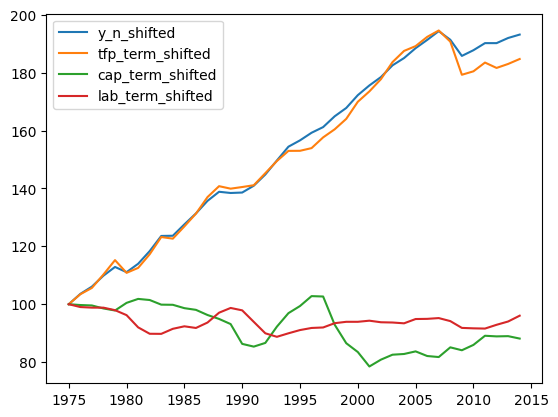

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


# データをStata形式から読み込みます。
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')

# データから'United Kingdom'のデータを選択し、必要な列（'year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna'）を抽出します。
data = pwt90.loc[pwt90['country'].isin(['United Kingdom'])][['year', 'countrycode', 'rgdpna', 'rkna', 'pop', 'emp', 'avh', 'labsh', 'rtfpna']]
# フィルタ条件として、年度が1975年以上かつ2015年以下のデータを選択します。欠損値を削除します。
data = data.loc[(data['year'] >= 1975) & (data['year'] <= 2015)].dropna()

# 追加変数の計算

#'alpha'列を計算し、'labsh'から1を引いた値として設定します。
data['alpha'] = 1 - data['labsh']
#'y_n'列を計算し、'rgdpna'を'emp'で割った値として設定します（GDP per worker）
data['y_n'] = data['rgdpna'] / data['emp']  # Y/N
#'hours'列を計算し、'emp'と'avh'を掛けた値として設定します（労働時間）
data['hours'] = data['emp'] * data['avh']  # L
#'tfp_term'列を計算し、'rtfpna'を(1 / (1 - 'alpha'))のべき乗した値として設定します（技術進歩の項）
data['tfp_term'] = data['rtfpna'] ** (1 / (1 - data['alpha']))  # A^(1/(1-alpha))
#'cap_term'列を計算し、('rkna' / 'rgdpna')を('alpha' / (1 - 'alpha'))のべき乗した値として設定します（資本深化の項）
data['cap_term'] = (data['rkna'] / data['rgdpna']) ** (data['alpha'] / (1 - data['alpha']))  # (K/Y)^(alpha/(1-alpha))
#'lab_term'列を計算し、'hours'を'pop'で割った値として設定します（労働力の増加の項）
data['lab_term'] = data['hours'] / data['pop']  # L/N

#データの整形
#'year'列でデータをソートします。'countrycode'でグループ化し、各グループ内で以下の変数を計算します。
data = data.sort_values('year').groupby('countrycode').apply(lambda x: x.assign(
    alpha=1 - x['labsh'],#'alpha'列を再計算し、1から'labsh'を引いた値として設定します。
    y_n_shifted=100 * x['y_n'] / x['y_n'].iloc[0],#'y_n_shifted'列を計算し、100 * 'y_n'を最初の行の値で割った値として設定します（初期値を100とする成長率）
    tfp_term_shifted=100 * x['tfp_term'] / x['tfp_term'].iloc[0],#'tfp_term_shifted'列を計算し、100 * 'tfp_term'を最初の行の値で割った値として設定します。
    cap_term_shifted=100 * x['cap_term'] / x['cap_term'].iloc[0],#'cap_term_shifted'列を計算し、100 * 'cap_term'を最初の行の値で割った値として設定します。
    lab_term_shifted=100 * x['lab_term'] / x['lab_term'].iloc[0] #'lab_term_shifted'列を計算し、100 * 'lab_term'を最初の行の値で割った値として設定します。
)).reset_index(drop=True).dropna()

#データの表示
#dataの最初の10行を表示します
print(data.head(10))

# データのプロット
plt.plot(data['year'], data['y_n_shifted'], label='y_n_shifted')#'y_n_shifted'（GDP per workerの成長率）
plt.plot(data['year'], data['tfp_term_shifted'], label='tfp_term_shifted')#'tfp_term_shifted'（技術進歩の成長率）
plt.plot(data['year'], data['cap_term_shifted'], label='cap_term_shifted')#'cap_term_shifted'（資本深化の成長率）
plt.plot(data['year'], data['lab_term_shifted'], label='lab_term_shifted')#'lab_term_shifted'（労働力の増加の成長率）
plt.legend()
plt.show()

# 🚨あとで削除🚨 growth_comp_2023.ipynb

このコードは、国別のデータから成長率とソロー残差を計算し、各国の成長率と資本シェアの平均を計算するものです。

In [17]:
import pandas as pd
import numpy as np


#2つのデータフレームを作成
pwt90 = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt90.dta')
pwt1001 = pd.read_stata('https://dataverse.nl/api/access/datafile/354098')

#pwt90データセットから必要な列を選択し、"Australia"と"Austria"の2つの国のデータを抽出します
data = pwt90.loc[pwt90['country'].isin(["Australia", "Austria"])][['year', 'countrycode', 'rgdpna', 'rkna', 'emp', 'labsh']]
#年が2000年から2015年の範囲内にあるデータのみを選択し、欠損値を除外します
data = data.loc[(data['year'] >= 2000) & (data['year'] <= 2015)].dropna()

#'y_pc'列は、実質GDPを雇用者数で割ったものの対数を表しており、1人当たりのGDPを示します
data['y_pc'] = np.log(data['rgdpna'] / data['emp'])  # GDP per worker
#'k_pc'列は、実質資本を雇用者数で割ったものの対数を表し、1人当たりの資本を示します
data['k_pc'] = np.log(data['rkna'] / data['emp'])  # Capital per worker
#'a'列は、1から'labsh'列を引いた値であり、資本シェアを示しています
data['a'] = 1 - data['labsh']  # Capital share

#データを年で並べ替え
data = data.sort_values('year')

#'countrycode'でグループ化
grouped_data = data.groupby('countrycode')

#1人当たりGDPの成長率を計算
data['g'] = (grouped_data['y_pc'].diff() * 100)  # Growth rate of GDP per capita

#欠損値を削除します
data = data.dropna()

#dataを'countrycode'でグループ化して、'g'列の平均値と'a'列の平均値を計算
summary = data.groupby('countrycode').agg({'g': 'mean',
                                       'a': "mean"})

#summary['Growth Rate']とsummary['Capital Share']という新しい列を作成し、それぞれの列に'g'と'a'の値をコピーします。
summary['Growth Rate'] = summary['g']
summary['Capital Share'] = summary['a']

#集計結果をコンソールに表示
print(summary)

                    g         a  Growth Rate  Capital Share
countrycode                                                
AUS          0.583894  0.429773     0.583894       0.429773
AUT          0.148971  0.421660     0.148971       0.421660
